In [2]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import torchvision
import math
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


torch.__version__, torch.cuda.is_available()

('1.11.0', True)

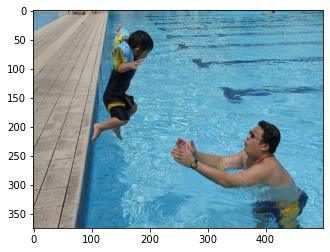

In [3]:


base_dir = "/home/wushan/Desktop/data/VOC2012/train/JPEGImages/"
def imshow(img_file):
    image =Image.open(os.path.join(base_dir,img_file))
    plt.imshow(image)
    return image

example = imshow("2012_004331.jpg")

### Flip
- Horizontal flip is a common approach. It always leads to a better performance.
- Flip at vertical direction is rare used. It does not make sense in many cases.

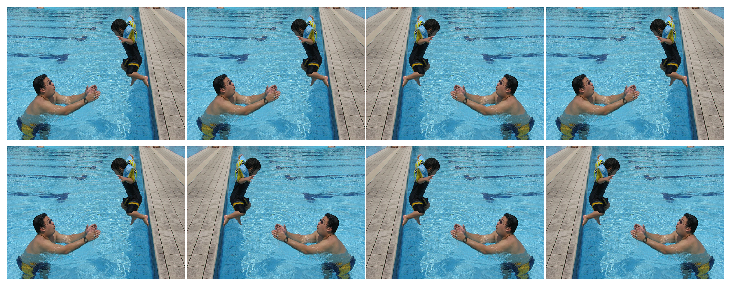

In [3]:
from img import imgs_show

def apply(img, aug, rows=2, cols=4):
    aug_imgs = [aug(img) for _ in range(rows * cols)]
    imgs_show(aug_imgs, rows)

apply(example, torchvision.transforms.RandomHorizontalFlip(p=0.5))

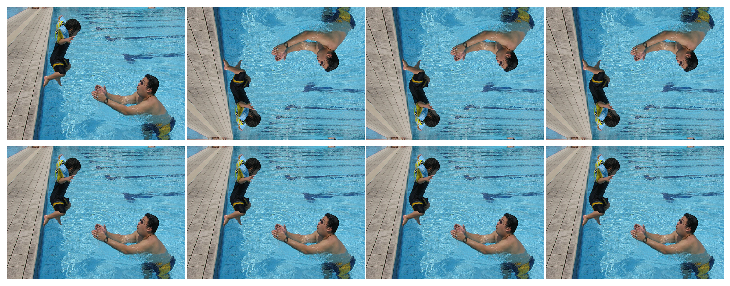

In [4]:
apply(example, torchvision.transforms.RandomVerticalFlip())

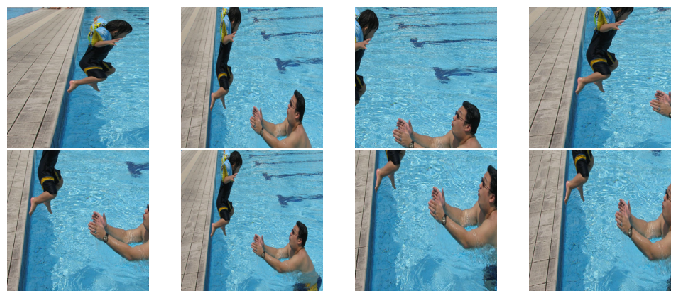

In [5]:
resize_aug = torchvision.transforms.RandomResizedCrop((200,200), scale=(0.3, 1.0), ratio = (0.5, 2))
apply(example, resize_aug)

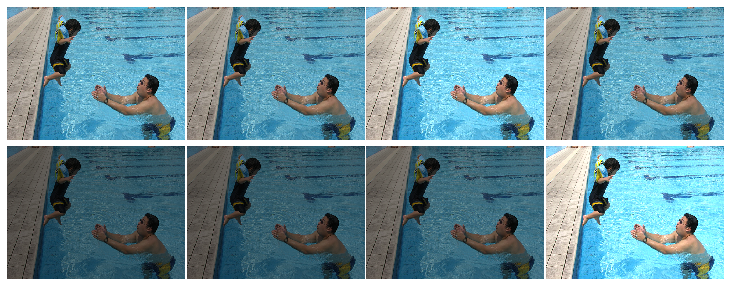

In [6]:
brightness_aug = torchvision.transforms.ColorJitter(brightness=0.5)
apply(example, brightness_aug)

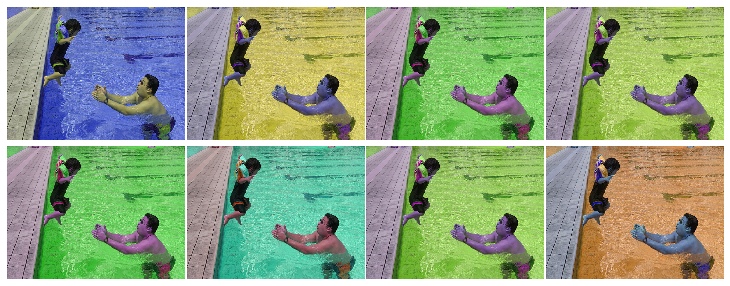

In [7]:
hue_aug = torchvision.transforms.ColorJitter(hue=0.5)
apply(example, hue_aug)

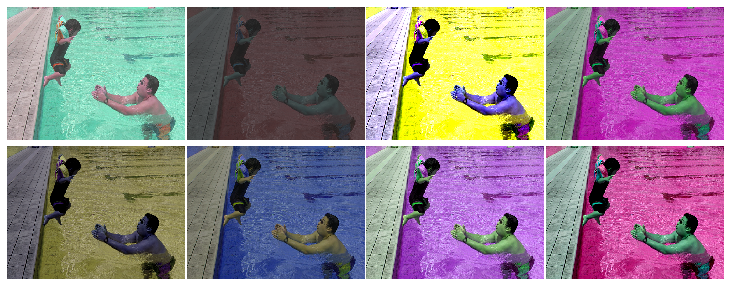

In [8]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(example, color_aug)

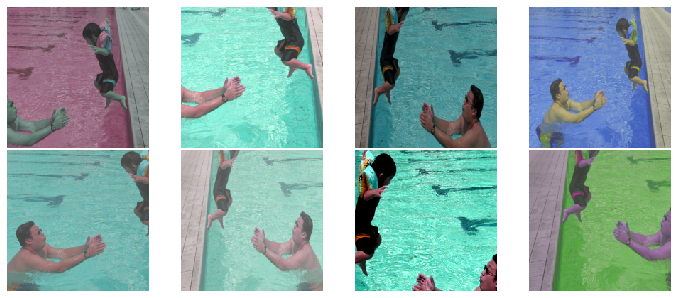

In [9]:
compose_aug = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(), resize_aug, color_aug]
)

apply(example, compose_aug)

Files already downloaded and verified


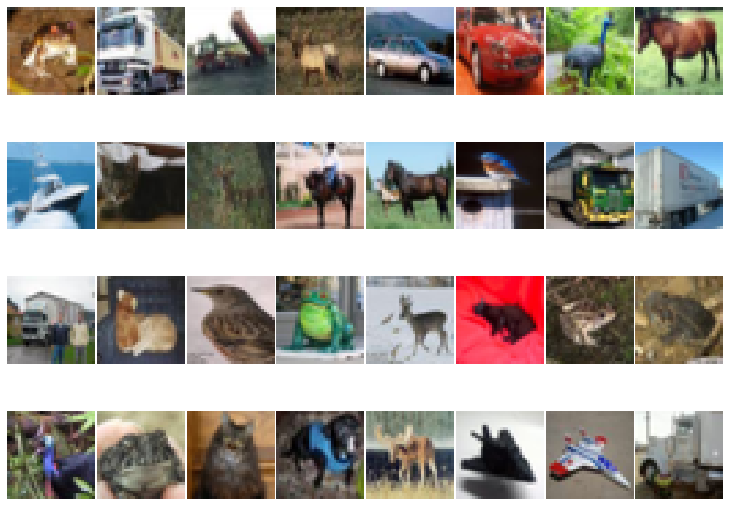

In [10]:

cifar10_dir = "/home/wushan/Desktop/data/cifar10"
all_images = torchvision.datasets.CIFAR10(train=True, root = cifar10_dir, download=True)

imgs_show([all_images[i][0] for i in range(32)], 4)

In [11]:
from train import train

train_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ColorJitter(0.1,0.1,0.1,0.1),
    torchvision.transforms.ToTensor()
])

test_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

def load_cifar10(train, aug, batch_size):
    available_cpu_count = len(os.sched_getaffinity(0)) // 2 # Develop server memory capacity issue
    dataset = torchvision.datasets.CIFAR10(cifar10_dir, train, aug, download=True)
    dataloader = DataLoader(dataset, batch_size, shuffle = train, num_workers = available_cpu_count)
    return dataloader


class Model(nn.Module):
    """
    Base on ResNet-18 without pretraining.
    """
    def __init__(self, output=10):
        super().__init__()
        # From scratch
        self.net = torchvision.models.resnet18(False)
        # self.net = torchvision.models.resnet34(False)
        # Approach 1: concate another classifier layer
        # self.dropout = nn.Dropout(0.5)
        # self.output = nn.Linear(1000,output)

        # Approach 2: Just replace the fc layer.
        self.net.fc = nn.Linear(self.net.fc.in_features, output)

        self.__init()
    
    def __init(self):
        def init_weights(m):
            if type(m) in [nn.Linear, nn.Conv2d]:
                nn.init.kaiming_normal_(m.weight)
        self.apply(init_weights)

    def forward(self, X):
        # Approach 1
        # res_output = self.dropout(self.net(X))
        # return self.output(torch.relu(res_output))

        # Approach 2
        return self.net(X)


In [12]:
# Approach 1: Training from scratch
# Only one GPU -_-#.
model, device= Model(), torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size, lr, epochs = 256, 1e-3, 10
optimizer = torch.optim.Adam(model.parameters(), lr= lr)
criterion = nn.CrossEntropyLoss(reduction="none")

train_data = load_cifar10(True, train_aug, batch_size)
test_data = load_cifar10(False, test_aug, batch_size)

total_param = sum([it.numel() for it in model.parameters()])
print(f"Total training parameters: {total_param:,}")

train(model, optimizer, criterion, train_data, test_data, epochs, device)

Files already downloaded and verified
Files already downloaded and verified
Total training parameters: 11,181,642


epoch 1/10, loss:1.54, acc:45.85%: 100%|██████████| 196/196 [00:38<00:00,  5.15it/s]


Validate accuracy at epoch 1: 45.06%


epoch 2/10, loss:1.34, acc:52.65%: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Validate accuracy at epoch 2: 57.49%


epoch 3/10, loss:1.21, acc:57.16%: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Validate accuracy at epoch 3: 57.30%


epoch 4/10, loss:1.12, acc:60.49%: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Validate accuracy at epoch 4: 67.08%


epoch 5/10, loss:1.04, acc:63.12%: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]


Validate accuracy at epoch 5: 62.64%


epoch 6/10, loss:0.98, acc:65.28%: 100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Validate accuracy at epoch 6: 66.84%


epoch 7/10, loss:0.93, acc:67.09%: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Validate accuracy at epoch 7: 71.61%


epoch 8/10, loss:0.89, acc:68.67%: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]


Validate accuracy at epoch 8: 71.84%


epoch 9/10, loss:0.85, acc:70.14%: 100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Validate accuracy at epoch 9: 72.59%


epoch 10/10, loss:0.81, acc:71.44%: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Validate accuracy at epoch 10: 69.56%
